  Using cached AgglomCluster-2.0.7.tar.gz (326 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for AgglomCluster
Failed to build AgglomCluster
Note: you may need to restart the kernel to use updated packages.


  DEPRECATION: Building 'AgglomCluster' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'AgglomCluster'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [58 lines of output]
      c:\Users\jayanth\AppData\Local\Programs\Python\Python313\Lib\site-packages\setuptools\dist.py:601: SetuptoolsDeprecationWarning: Invalid dash-separated key 'description-file' in 'metadata' (setup.cfg), please use the underscore name 'description_file' instead.
      !!
      
              ********************************************************************************
         

In [42]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt

In [51]:
# Load the data
df = pd.read_csv('data/train_FD002.csv')
df = df.dropna(axis=1)
df.head()


,1,1.1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071
0,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665
1,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723
2,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701
3,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286
4,1,6,25.0045,0.6205,60.0,462.54,537.02,1266.38,1048.72,7.05,...,164.27,2028.01,7868.87,10.8912,0.02,306,1915,84.93,14.28,8.5590


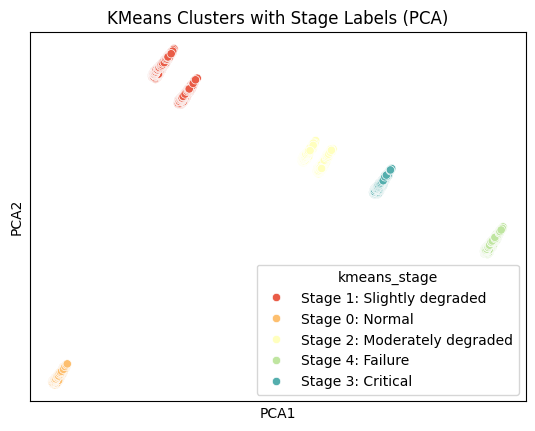

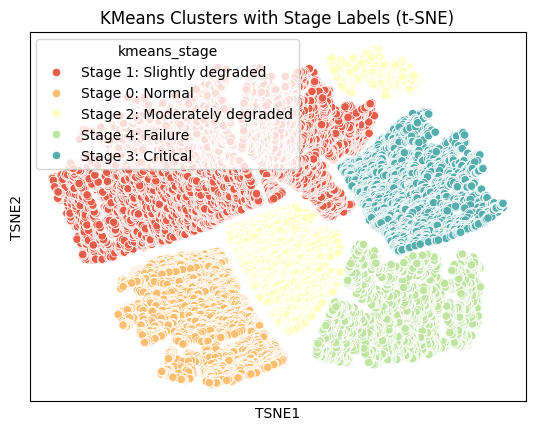

KMeans Silhouette Score: 0.59


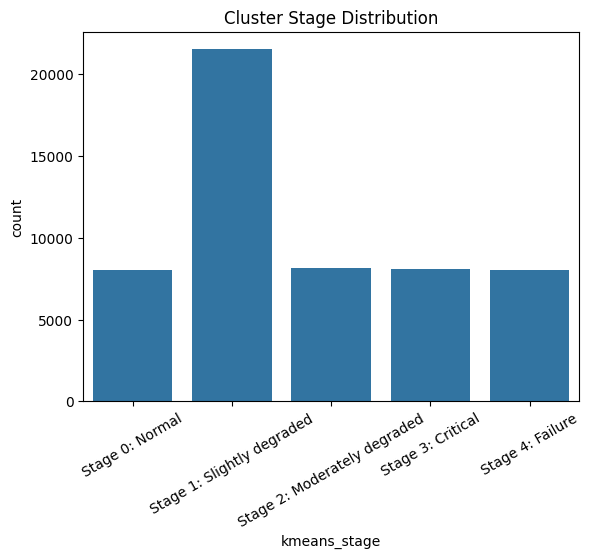

In [52]:
X = df.copy()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
df['kmeans_cluster'] = kmeans.fit_predict(X_scaled)

# Apply Agglomerative clustering
agglo = AgglomerativeClustering(n_clusters=5)
df['agglo_cluster'] = agglo.fit_predict(X_scaled)

# ---------- Assign Stage Labels Based on Feature Degradation ----------

# Step 1: Compute average values per cluster
cluster_summary = df.groupby('kmeans_cluster').mean()

# Step 2: Choose features indicative of degradation (modify as needed)
# Pick top features you think degrade (e.g., temps, pressures, etc.)
# If unsure, pick first 5–10 real-valued sensor columns
degradation_features = cluster_summary.iloc[:, :10]  # adjust if needed

# Step 3: Rank clusters by average degradation
degradation_metric = degradation_features.mean(axis=1)
ranked_clusters = degradation_metric.sort_values().index  # low → high degradation

# Step 4: Assign stage names
stage_names = [
    "Stage 0: Normal", 
    "Stage 1: Slightly degraded", 
    "Stage 2: Moderately degraded", 
    "Stage 3: Critical", 
    "Stage 4: Failure"
]
cluster_to_stage = {cluster: stage_names[i] for i, cluster in enumerate(ranked_clusters)}
df['kmeans_stage'] = df['kmeans_cluster'].map(cluster_to_stage)

# ---------- PCA Projection ----------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df['PCA1'], df['PCA2'] = X_pca[:, 0], X_pca[:, 1]

sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='kmeans_stage', palette='Spectral')
plt.title("KMeans Clusters with Stage Labels (PCA)")
plt.xticks([])
plt.yticks([])
plt.show()

# ---------- t-SNE Projection ----------
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
df['TSNE1'], df['TSNE2'] = X_tsne[:, 0], X_tsne[:, 1]

sns.scatterplot(data=df, x='TSNE1', y='TSNE2', hue='kmeans_stage', palette='Spectral')
plt.title("KMeans Clusters with Stage Labels (t-SNE)")
plt.xticks([])
plt.yticks([])
plt.show()

# ---------- Silhouette Score ----------
score = silhouette_score(X_scaled, df['kmeans_cluster'])
print(f"KMeans Silhouette Score: {score:.2f}")

# ---------- Stage distribution visualization ----------
sns.countplot(data=df, x='kmeans_stage', order=stage_names)
plt.title("Cluster Stage Distribution")
plt.xticks(rotation=30)
plt.show()

In [54]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt
from kmeans_gpu import KMeans
from AgglomCluster import AgglomerativeClustering

# Load the data
df = pd.read_csv('data/train_FD002.csv')
df = df.dropna(axis=1)
X = df.copy()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
df['kmeans_cluster'] = kmeans.fit_predict(X_scaled)

# Apply Agglomerative clustering
agglo = AgglomerativeClustering(n_clusters=5)
df['agglo_cluster'] = agglo.fit_predict(X_scaled)

# ---------- Assign Stage Labels Based on Feature Degradation ----------

# Step 1: Compute average values per cluster
cluster_summary = df.groupby('kmeans_cluster').mean()

# Step 2: Choose features indicative of degradation (modify as needed)
degradation_features = cluster_summary.iloc[:, :10]  # adjust if needed

# Step 3: Rank clusters by average degradation
degradation_metric = degradation_features.mean(axis=1)
ranked_clusters = degradation_metric.sort_values().index  # low → high degradation

# Step 4: Assign stage names
stage_names = [
    "Stage 0: Normal", 
    "Stage 1: Slightly degraded", 
    "Stage 2: Moderately degraded", 
    "Stage 3: Critical", 
    "Stage 4: Failure"
]
cluster_to_stage = {cluster: stage_names[i] for i, cluster in enumerate(ranked_clusters)}
df['kmeans_stage'] = df['kmeans_cluster'].map(cluster_to_stage)

# ---------- PCA Projection ----------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df['PCA1'], df['PCA2'] = X_pca[:, 0], X_pca[:, 1]

sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='kmeans_stage', palette='Spectral')
plt.title("KMeans Clusters with Stage Labels (PCA)")
plt.xticks([])
plt.yticks([])
plt.show()

# ---------- t-SNE Projection ----------
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
df['TSNE1'], df['TSNE2'] = X_tsne[:, 0], X_tsne[:, 1]

sns.scatterplot(data=df, x='TSNE1', y='TSNE2', hue='kmeans_stage', palette='Spectral')
plt.title("KMeans Clusters with Stage Labels (t-SNE)")
plt.xticks([])
plt.yticks([])
plt.show()

# ---------- Silhouette Score ----------
score = silhouette_score(X_scaled, df['kmeans_cluster'])
print(f"KMeans Silhouette Score: {score:.2f}")

# ---------- Stage distribution visualization ----------
sns.countplot(data=df, x='kmeans_stage', order=stage_names)
plt.title("Cluster Stage Distribution")
plt.xticks(rotation=30)
plt.show()

ModuleNotFoundError: No module named 'AgglomCluster'